In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
from scipy.ndimage import gaussian_filter1d
from scipy.signal import windows
import json

To calculate analytical SNR:

The magnitude of signal is $m = H^{-1}f$ where $H = A^TN^{-1}A$ and $f = A^TN^{-1}d$.

We know from Maximum-Likelihood theory that $\big<\delta_m\delta_m^T \big> = H^{-1}$. Therefore, $\sigma_m = H^{-1/2}$.
In time-domain, we define SNR as: $SNR = \frac{m}{\sigma_m}$ where all quantities are properly normalized as given above. Therefore, $SNR = H^{-1/2}f = \frac{f}{\sqrt{(H)}}$ (The last equality follows if H is a scalar, which it is if we're only fitting a scaling parameter.)

This is also equivalent to the _improvement_ in chisquare of our fit. $\Delta \chi^2 = -f^TH^{-1}f = \frac{-f^2}{H} $

We can add the squares of SNR to get combined SNR.

## Fourier Transform convention used here is the same as LIGO tutorial
refer paper 

N = 131072

sampling frequency fs = 4096

dt = 1/fs

df = 1/(N*dt) = fs/N

## Windows and whitening

A Tukey window has been used here, as it's recommended in the LIGO paper. Tukey window also has a nice flat region, so reduction in power is less.

Blackman window (that minimizes spectral leakage) gives slightly better SNR for GW150914. It's used in LIGO tutorial. But I've stuck with Tukey for all events here.

Other windows I tried: DPSS (minimizes power in sidelobes), Kaiser, Hann, Hamming

To calculate SNR in time-domain using analytical method, data has been whitened in the fourier domain. _Matched Filtering is actually equivalent to whitening as shown in code comments._

## Bugs

There might be an issue with normalization fa

In [93]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_raw(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    
    dataFile.close()
    return strain,dt,utc

In [94]:
rootdir = './LOSC_Event_Tutorial/'
with open(rootdir+"BBH_events_v3.json", "r") as read_file:
    events = json.load(read_file)

In [95]:
def fit(fname, template_name, ax, winfunc,args=(), lowcutoff=200,highcutoff=50000,sigma_smooth=5,corrcutoff=15000, hanford=True):
    rootdir = './LOSC_Event_Tutorial/'

    strain,dt,utc = read_raw(rootdir+fname)
    th,tl = read_template(rootdir+template_name)
    if(hanford):
        template = th
        title = 'Hanford'
    else:
        template = tl
        title = 'Livingston'
    
    n = len(strain)
    fs=4096
#     dt = 1/fs
    df = fs/n
    lowcutoff = int(lowcutoff/df) # for emulating bandpassing
    highcutoff = int(highcutoff/df)
    win = winfunc(n,*args)
    A = template*win
    d = strain*win
    dwin = np.fft.fft(d)*dt
    tempwin = np.fft.fft(A)*dt 
    
    NoisePS = np.abs(dwin)**2 
    NoisePS_smooth = gaussian_filter1d(NoisePS, 10)
    bins = np.arange(len(dwin))
    ax[0].set_title(title)
    ax[0].loglog(bins*df,np.sqrt(NoisePS),label='Noise ASD raw')
    ax[0].loglog(bins*df,np.sqrt(NoisePS_smooth),label='Noise ASD smoothed')
    ax[0].loglog(bins*df,np.abs(tempwin),label='template ASD')
    ax[0].set_xlim([100*df,fs/2])
    ax[0].set_ylabel('ASD (strain/$\sqrt{Hz}$)')
    ax[0].set_xlabel('Frequency (Hz)')
    ax[0].legend()

    
    
    

#     sigma = np.sqrt(np.sum(np.abs(tempwin)**2/NoisePS_smooth)*df)
    
    # total power of BANDPASSED signal
    sigma1 = np.sqrt(np.sum(np.abs(tempwin[lowcutoff:highcutoff])**2/NoisePS_smooth[lowcutoff:highcutoff])*df)
    
    filter_ft = tempwin/NoisePS_smooth 
    # this is equivalent to pre-whitening data and template separately, such as
    # filter_output = dwin/np.sqrt(NoisePS_smooth) * tempwin.conjugate()/np.sqrt(NoisePS_smooth)
    filter_output = dwin * np.conjugate(filter_ft)
    corr = 2*np.fft.ifft(filter_output)*n*df
    LIGOsnr = corr/sigma1 # this is how LIGO tutorial calculates SNR
    
    # calculate and return the time index where max corr occurs
    indmax = np.argmax(corr)
    
    # As we can see above, our filter actually weights the whitened input data by the Noise ASD (sqrt(NoisePS_smooth))
    # i.e. points that have higher noise than template are actively downweighted and vice-versa
    # First, implement some cutoffs to resemble the range of frequencies that LIGO analysis actually uses.
    relevant_signal_amplitude = np.abs(tempwin)[lowcutoff:highcutoff] # sum all power between cutoffs
    relevant_noise_amplitude = np.sqrt(NoisePS_smooth[lowcutoff:highcutoff])
    weights = relevant_signal_amplitude/relevant_noise_amplitude
    total = weights.sum()
    p = 0
    indhalf=0
    for i in range(len(weights)):
        p = p+weights[i]
        if(p>0.5*total):
            indhalf = i
            break

    print("for",title,"Half of filter weight comes till frequency bin", indhalf, "correponding to frequency", indhalf*df, "Hz")
    
    ax[1].plot(np.arange(len(LIGOsnr))*dt, np.abs(LIGOsnr))
    ax[1].set_title('Signal correlation')
    ax[1].set_ylabel('SNR (normalized correlation)')
    ax[1].set_xlabel('time delay (seconds)')
    ax[1].axvline((n-corrcutoff)*dt, color='black', linestyle='--')
    plt.tight_layout()
    # let us formally calculate whitened quantities so that we can transform back to time domain
    A_white = np.fft.ifft(tempwin/np.sqrt(NoisePS_smooth))*n*df
    d_white = np.fft.ifft(dwin/np.sqrt(NoisePS_smooth))*n*df
    H = np.sum(np.abs(A_white)**2)*dt # total power in time domain
    mynoise = np.std(corr[-corrcutoff:])
    mysignal = np.max(np.abs(corr))
    
#     vector = 
    
    analysnr = np.max(np.abs(corr))/np.sqrt(H) # = LIGO SNR; factor of 2 makes analytical SNR = LIGO SNR
    snr = mysignal/mynoise # this is the time-domain estimate from actual scatter

    
    return indmax, snr, np.max(np.abs(LIGOsnr)), analysnr

In [96]:
eventnames = list(events.keys())

### Bandpassed power used for LIGO method. hence SNR higher. Time domain power used in analytical method NOT bandpassed. Otherwise both would be equal. (Replace sigma1 by sigma in above function)

for Hanford Half of filter weight comes till frequency bin 3022 correponding to frequency 94.4375 Hz
for Livingston Half of filter weight comes till frequency bin 3209 correponding to frequency 100.28125 Hz
SNR for event GW150914: Hanford 17.9, Livingston 12.8
SNR (LIGO method) for event GW150914: Hanford  9.8, Livingston  6.9
SNR (analytical) for event GW150914: Hanford  6.5, Livingston  4.6
Combined SNR is 22.1
Time difference b/w wave at Hanford and Livingston: 5.4 ms


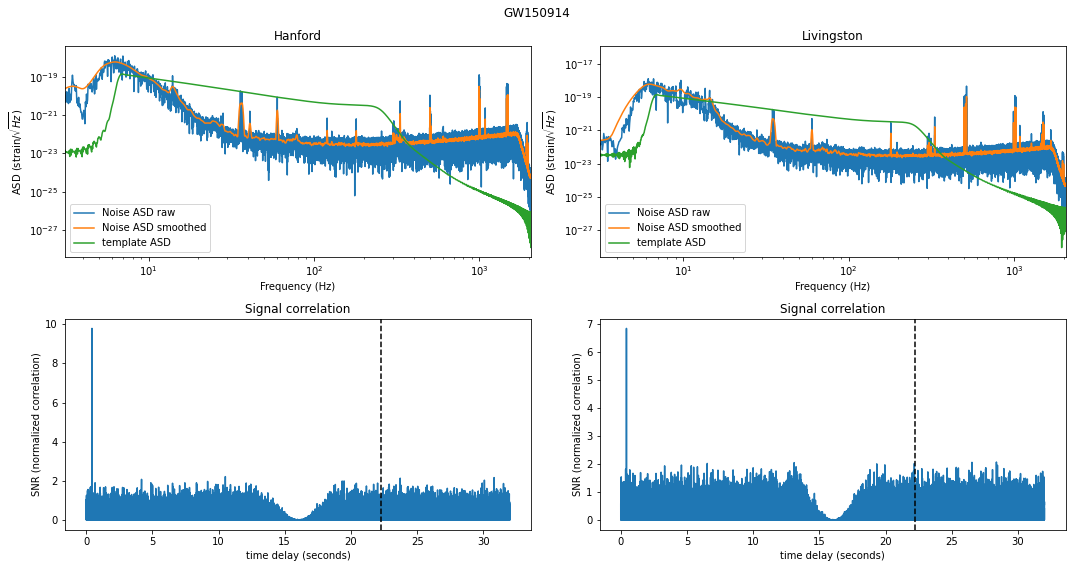

In [97]:
event = eventnames[0]
fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle(event)
ax1 = ax[:,0]
ax2 = ax[:,1]
band = events[event]['fband']
ind1, snr1, snrfft1, analsnr1 = fit(events[event]['fn_H1'], events[event]['fn_template'], ax1, windows.tukey, args=(0.2,),\
                                    lowcutoff=band[0],highcutoff=band[1], corrcutoff=40000)
ind2, snr2, snrfft2, analsnr2 = fit(events[event]['fn_L1'], events[event]['fn_template'], ax2, windows.tukey, args=(0.2,), \
                                    lowcutoff=band[0], highcutoff=band[1], corrcutoff=40000, hanford=False)

print(f"SNR for event {event}: Hanford {snr1:4.1f}, Livingston {snr2:4.1f}")
print(f"SNR (LIGO method) for event {event}: Hanford {snrfft1:4.1f}, Livingston {snrfft2:4.1f}")
print(f"SNR (analytical) for event {event}: Hanford {analsnr1:4.1f}, Livingston {analsnr2:4.1f}")

# ratio1 = snr1/snr2
# ratio2 = snrfft1/snrfft2
# ratio3 = analsnr1/analsnr2

timediff = np.abs(ind1-ind2)/4096
# print("ratios are:", ratio1, ratio2, ratio3)
combinedsnr = np.sqrt(snr1**2+snr2**2)
print(f"Combined SNR is {combinedsnr:4.1f}")
print(f"Time difference b/w wave at Hanford and Livingston: {timediff*1000:2.1f} ms")



for Hanford Half of filter weight comes till frequency bin 2772 correponding to frequency 86.625 Hz
for Livingston Half of filter weight comes till frequency bin 3079 correponding to frequency 96.21875 Hz
SNR for event LVT151012: Hanford  6.2, Livingston  5.6
SNR (LIGO method) for event LVT151012: Hanford  3.4, Livingston  3.0
SNR (analytical) for event LVT151012: Hanford  2.2, Livingston  2.1
Combined SNR is  8.3
Time difference b/w wave at Hanford and Livingston: 2.0 ms


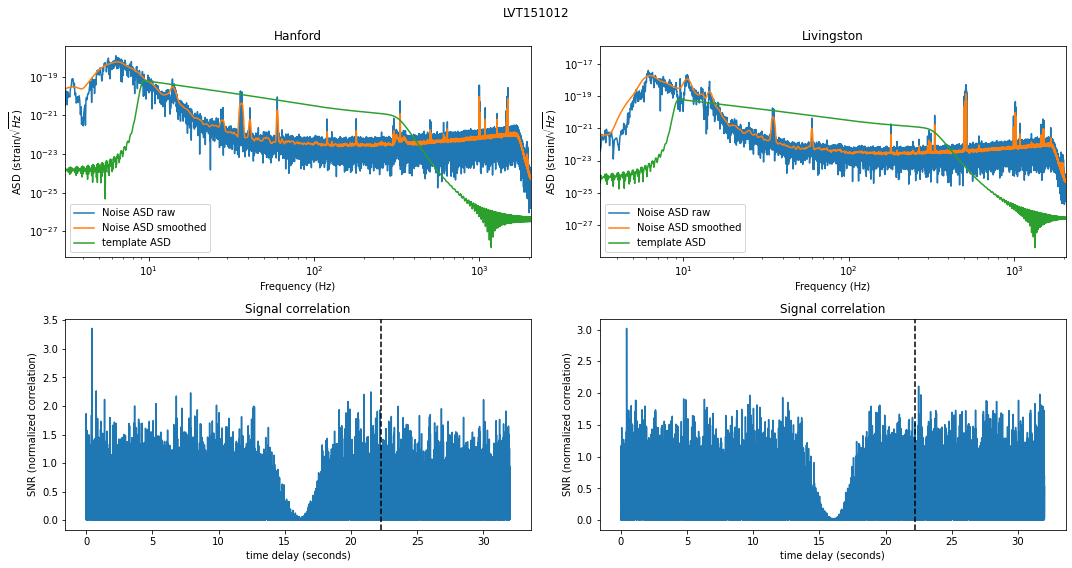

In [101]:
event = eventnames[1]
fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle(event)
ax1 = ax[:,0]
ax2 = ax[:,1]
band = events[event]['fband']
ind1, snr1, snrfft1, analsnr1 = fit(events[event]['fn_H1'], events[event]['fn_template'], ax1, windows.tukey, args=(0.2,),\
                                    lowcutoff=band[0],highcutoff=band[1], corrcutoff=40000)
ind2, snr2, snrfft2, analsnr2 = fit(events[event]['fn_L1'], events[event]['fn_template'], ax2, windows.tukey, args=(0.2,), \
                                    lowcutoff=band[0], highcutoff=band[1], corrcutoff=40000, hanford=False)

print(f"SNR for event {event}: Hanford {snr1:4.1f}, Livingston {snr2:4.1f}")
print(f"SNR (LIGO method) for event {event}: Hanford {snrfft1:4.1f}, Livingston {snrfft2:4.1f}")
print(f"SNR (analytical) for event {event}: Hanford {analsnr1:4.1f}, Livingston {analsnr2:4.1f}")

# ratio1 = snr1/snr2
# ratio2 = snrfft1/snrfft2
# ratio3 = analsnr1/analsnr2

timediff = np.abs(ind1-ind2)/4096
# print("ratios are:", ratio1, ratio2, ratio3)
combinedsnr = np.sqrt(snr1**2+snr2**2)
print(f"Combined SNR is {combinedsnr:4.1f}")
print(f"Time difference b/w wave at Hanford and Livingston: {timediff*1000:2.1f} ms")



for Hanford Half of filter weight comes till frequency bin 3423 correponding to frequency 106.96875 Hz
for Livingston Half of filter weight comes till frequency bin 4519 correponding to frequency 141.21875 Hz
SNR for event GW151226: Hanford  9.8, Livingston  5.2
SNR (LIGO method) for event GW151226: Hanford  5.4, Livingston  2.8
SNR (analytical) for event GW151226: Hanford  3.6, Livingston  1.9
Combined SNR is 11.2
Time difference b/w wave at Hanford and Livingston: 0.5 ms


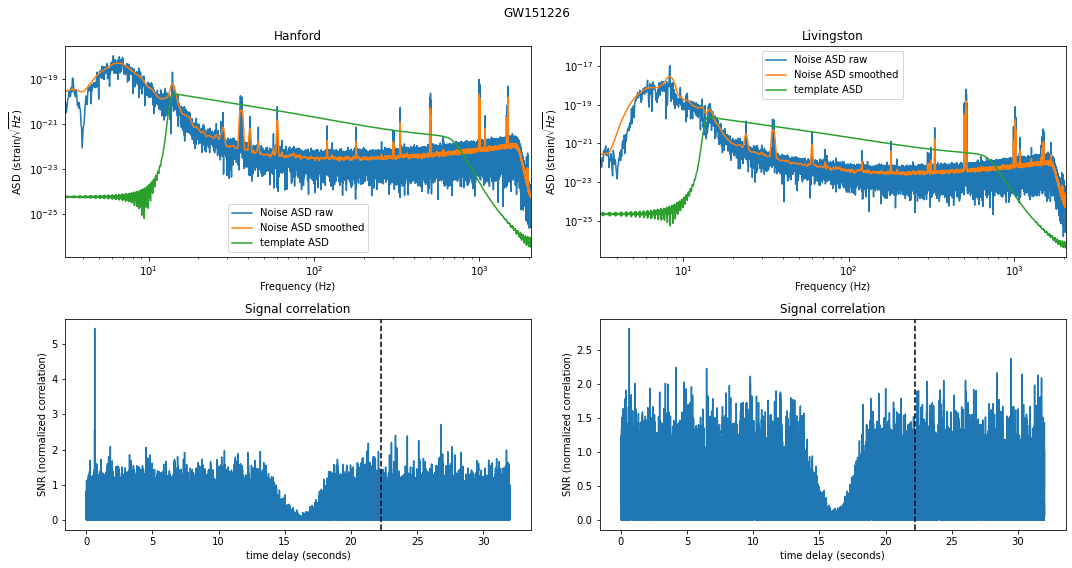

In [102]:
event = eventnames[2]
fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle(event)
ax1 = ax[:,0]
ax2 = ax[:,1]
band = events[event]['fband']
ind1, snr1, snrfft1, analsnr1 = fit(events[event]['fn_H1'], events[event]['fn_template'], ax1, windows.tukey, args=(0.2,),\
                                    lowcutoff=band[0],highcutoff=band[1], corrcutoff=40000)
ind2, snr2, snrfft2, analsnr2 = fit(events[event]['fn_L1'], events[event]['fn_template'], ax2, windows.tukey, args=(0.2,), \
                                    lowcutoff=band[0], highcutoff=band[1], corrcutoff=40000, hanford=False)

print(f"SNR for event {event}: Hanford {snr1:4.1f}, Livingston {snr2:4.1f}")
print(f"SNR (LIGO method) for event {event}: Hanford {snrfft1:4.1f}, Livingston {snrfft2:4.1f}")
print(f"SNR (analytical) for event {event}: Hanford {analsnr1:4.1f}, Livingston {analsnr2:4.1f}")

# ratio1 = snr1/snr2
# ratio2 = snrfft1/snrfft2
# ratio3 = analsnr1/analsnr2

timediff = np.abs(ind1-ind2)/4096
# print("ratios are:", ratio1, ratio2, ratio3)
combinedsnr = np.sqrt(snr1**2+snr2**2)
print(f"Combined SNR is {combinedsnr:4.1f}")
print(f"Time difference b/w wave at Hanford and Livingston: {timediff*1000:2.1f} ms")



for Hanford Half of filter weight comes till frequency bin 3055 correponding to frequency 95.46875 Hz
for Livingston Half of filter weight comes till frequency bin 2797 correponding to frequency 87.40625 Hz
SNR for event GW170104: Hanford  7.9, Livingston  7.3
SNR (LIGO method) for event GW170104: Hanford  4.3, Livingston  4.2
SNR (analytical) for event GW170104: Hanford  2.9, Livingston  2.7
Combined SNR is 10.8
Time difference b/w wave at Hanford and Livingston: 28973.1 ms


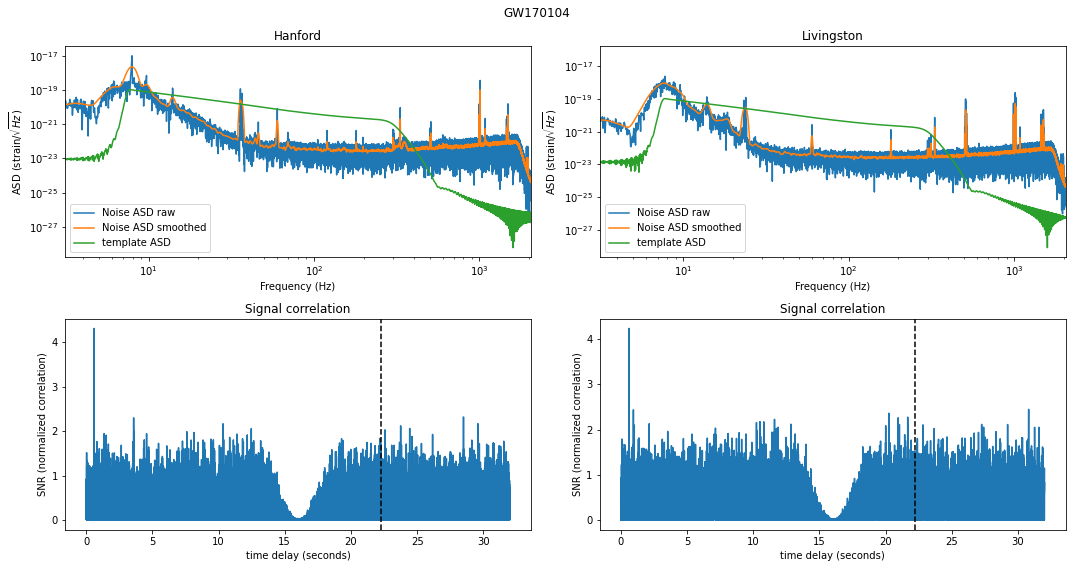

In [103]:
event = eventnames[3]
fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,8)
fig.suptitle(event)
ax1 = ax[:,0]
ax2 = ax[:,1]
band = events[event]['fband']
ind1, snr1, snrfft1, analsnr1 = fit(events[event]['fn_H1'], events[event]['fn_template'], ax1, windows.tukey, args=(0.2,),\
                                    lowcutoff=band[0],highcutoff=band[1], corrcutoff=40000)
ind2, snr2, snrfft2, analsnr2 = fit(events[event]['fn_L1'], events[event]['fn_template'], ax2, windows.tukey, args=(0.2,), \
                                    lowcutoff=band[0], highcutoff=band[1], corrcutoff=40000, hanford=False)

print(f"SNR for event {event}: Hanford {snr1:4.1f}, Livingston {snr2:4.1f}")
print(f"SNR (LIGO method) for event {event}: Hanford {snrfft1:4.1f}, Livingston {snrfft2:4.1f}")
print(f"SNR (analytical) for event {event}: Hanford {analsnr1:4.1f}, Livingston {analsnr2:4.1f}")

# ratio1 = snr1/snr2
# ratio2 = snrfft1/snrfft2
# ratio3 = analsnr1/analsnr2

timediff = np.abs(ind1-ind2)/4096
# print("ratios are:", ratio1, ratio2, ratio3)
combinedsnr = np.sqrt(snr1**2+snr2**2)
print(f"Combined SNR is {combinedsnr:4.1f}")
print(f"Time difference b/w wave at Hanford and Livingston: {timediff*1000:2.1f} ms")

